 **Note:** Igonre or comment jovian lines if you are running this notebook.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
print("done")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input/seg_test/forest/23933.jpg
./kaggle/input/seg_test/buildings/20553.jpg
./kaggle/input/seg_test/glacier/21842.jpg
./kaggle/input/seg_test/street/22387.jpg
./kaggle/input/seg_test/mountain/20584.jpg
./kaggle/input/seg_test/sea/22393.jpg
./kaggle/input/seg_train/forest/5109.jpg
./kaggle/input/seg_train/buildings/12536.jpg
./kaggle/input/seg_train/glacier/4217.jpg
./kaggle/input/seg_train/street/9733.jpg
./kaggle/input/seg_train/mountain/14147.jpg
./kaggle/input/seg_train/sea/6400.jpg
./kaggle/input/seg_pred/63.jpg
done


In [3]:
!python3 -m pip install --upgrade pip
%pip install torch
%pip install torchvision
%pip install matplotlib
print("done")

Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.
done


In [4]:
#import necessory libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

> # **Exploring the Dataset**

In [5]:
#project name
project_name = 'natural-scene-classification'

In [6]:
data_dir = "./kaggle/input/seg_train/"
test_data_dir = "./kaggle/input/seg_test"

In [7]:

building_files = os.listdir(data_dir + '/buildings')
print(f"Number of Buildings : {len(building_files)}")
print(building_files[:5])

Number of Buildings : 2191
['12536.jpg', '16750.jpg', '16988.jpg', '4571.jpg', '12244.jpg']


In [8]:
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [9]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


The images are rgb and have 150*150 pixel in each image

In [11]:
print(f"Images in training data : {len(dataset)}")
print(f"Images in test data : {len(test_dataset)}")

Images in training data : 14034
Images in test data : 3000


We have 14034 images in training data and 3000 images in test dataset.

In [12]:
print("Following classes are there : \n",dataset.classes)

Following classes are there : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [13]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

> # Visualising some images :

Label : buildings


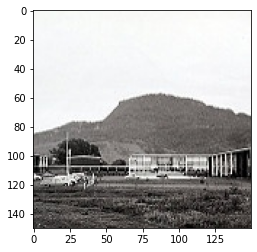

In [14]:
display_img(*dataset[0])

Label : glacier


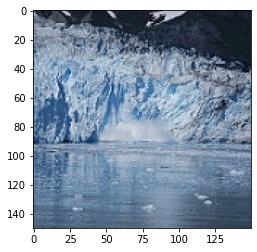

In [15]:
display_img(*dataset[5000])

Label : mountain


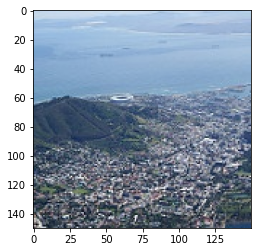

In [16]:
display_img(*dataset[8000])

> # Training and Validation Datasets : 

In [17]:
random_seed = 2021
torch.manual_seed(random_seed)

In [18]:
val_size = 2000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 12034
Length of Validation Data : 2000


In [19]:
batch_size = 128

> # Load the dataset into batches:

In [20]:
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

> # **Grid Of Train Data Images :**

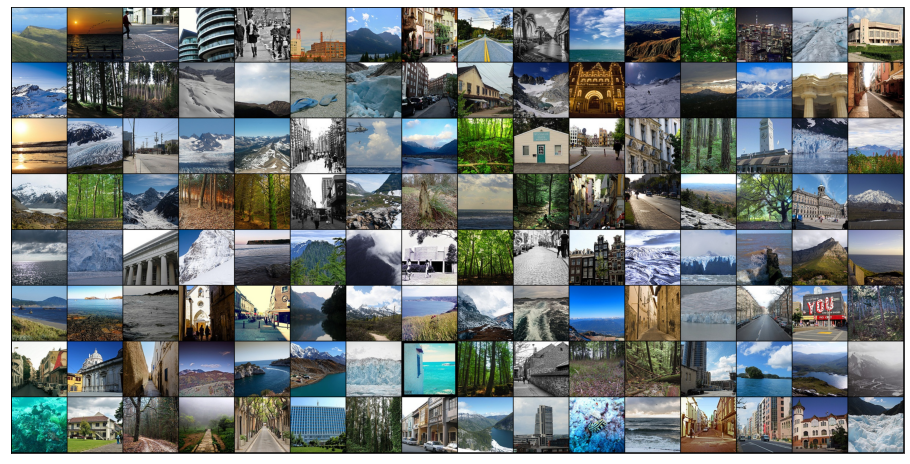

In [22]:
show_batch(train_dl)

> # Base Model for Image Classification:

In [ ]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Netural Scene Classfication Model:

In [ ]:
class NaturalSceneClassification(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = NaturalSceneClassification()
model

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

Helper Function or classes to Load Data into GPU

In [ ]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

> # **Model Fitting**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
#load the model to the device
model = to_device(NaturalSceneClassification(),device)

In [ ]:
#initial evaluation of the model
evaluate(model,val_dl)

In [ ]:
#set the no. of epochs, optimizer funtion and learning rate
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

> # Graphs for Model Accuracy and Losses :

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

> # Evaluate Test Data :

In [ ]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [ ]:
#save the model
torch.save(model.state_dict(), 'natural-scene-classification.pth')

> ## Predicting for invisual images:

In [ ]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

In [ ]:
from PIL import Image

#open image file
img = Image.open("../input/intel-image-classification/seg_pred/seg_pred/10004.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
#open image file
img = Image.open("../input/intel-image-classification/seg_pred/seg_pred/10100.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
#open image file
img = Image.open("../input/intel-image-classification/seg_pred/seg_pred/10241.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
img.shape

<!-- Save the parmeters to jovian plateform -->

In [ ]:
# import jovian

# jovian.log_dataset(dataset_url = data_dir, val_size = val_size, random_seed = random_seed)

# #save the hyperparameters to jovian plateform 
# #jovian.reset()
# jovian.log_hyperparams({
#     'num_epochs': num_epochs,
#     'opt_func': opt_func.__name__,
#     'batch_size': batch_size,
#     'lr': lr,
# })

# jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

# jovian.commit(project=project_name)